### 分詞

In [2]:
import torch
from transformers import pipeline
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = pipeline("token-classification", model=r"E:\\jupyter_notebook\\bert-base-chinese-ws", device=device)

In [3]:
def split_sentences(text):
    # 按標點切分句子
    pattern = r'[。！？；.!?;\n]'
    sentences = re.split(pattern, text)
    return [s.strip() for s in sentences if s.strip()]

In [4]:
def word_segment(text):
    result = pipe(text)
    processed_text = ''.join([' ' + entry['word']
                              if entry['entity'] == 'B'
                              else entry['word']
                              for entry in result])
    return processed_text.strip()

In [5]:
def process_text(text):
    # 先按句子拆分文本
    sentences = split_sentences(text)
    # 對每個句子進行分詞
    segmented_sentences = [word_segment(sentence) for sentence in sentences]
    # 使用空格拼接分詞後的句子
    segmented_text = ' '.join(segmented_sentences)
    return segmented_text

In [6]:
def process_files_in_folder(folder_path):
    # 遍歷指定文件夾中的所有文件，進行分詞
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            # 讀取文件內容
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
            
            # 分句並分詞
            segmented_content = process_text(content)
            
            # 將分詞後的內容寫回文件
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(segmented_content)


folder_path = r"F:\古籍處理數據\input\方言篇\txt版" 
process_files_in_folder(folder_path)


### 製作TF-IDF向量

In [7]:
def stopwords_list(file_path):
    "輸入以utf-8編碼的txt文件，文件以回車分隔停用詞"
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        stopwords = f.read().split('\n')
        stopwords = [word.strip() for word in stopwords if word.strip()]
        stopwords.extend(['\n', '\r','\r\n'])
    return stopwords

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import pandas as pd
import re

def tfidf(input_file_path,stopwords_list):
    """
    input_file_path:輸入以空格“ ”爲分隔符的已分詞的utf-8編碼的txt文件所在的文件夾地址;
    stopwords_list:列表形式。
    """
    # 創建TfidfVectorizer對象
    vectorizer = TfidfVectorizer(input='filename',encoding='utf-8',stop_words=stopwords_list)
    # 儲存所有文檔的路徑
    corpus_path = [os.path.join(input_file_path, f) for f in os.listdir(input_file_path) if f.endswith('.txt')]
    # 對所有文檔進行TF-IDF向量化
    tfidf_matrix = vectorizer.fit_transform(corpus_path)
    feature_names = vectorizer.get_feature_names_out() 
    dense = tfidf_matrix.todense() 
    denselist = dense.tolist() 
    df = pd.DataFrame(denselist, columns=feature_names) 
    df['書名'] = [re.search('《(.*?)》', os.path.splitext(os.path.basename(f))[0]).group(1) if re.search('《(.*?)》', os.path.splitext(os.path.basename(f))[0]) else os.path.splitext(os.path.basename(f))[0] for f in corpus_path]
    df.set_index('書名', inplace=True)
    return df

stopwords_list = stopwords_list(r"F:\古籍處理數據\stop_words.txt")
tfidf = tfidf(r'F:\古籍處理數據\input\方言篇\txt版',stopwords_list)
tfidf.to_excel(r'F:\古籍處理數據\input\方言篇\txt版\TF-IDF.xlsx', index=True)

### 計算餘弦相似度

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def cos_sim(tfidf):
    """
    tfidf: pd.DataFrame結構的TF-IDF向量列表
    """
    cosine_sim = cosine_similarity(tfidf)
    df_cosine_sim = pd.DataFrame(cosine_sim, columns=tfidf.index, index=tfidf.index)
    return df_cosine_sim

cos_sim = cos_sim(tfidf)
cos_sim.to_excel(r'F:\古籍處理數據\input\方言篇\txt版\cosine_similarities.xlsx', index=True)

### 繪製熱圖

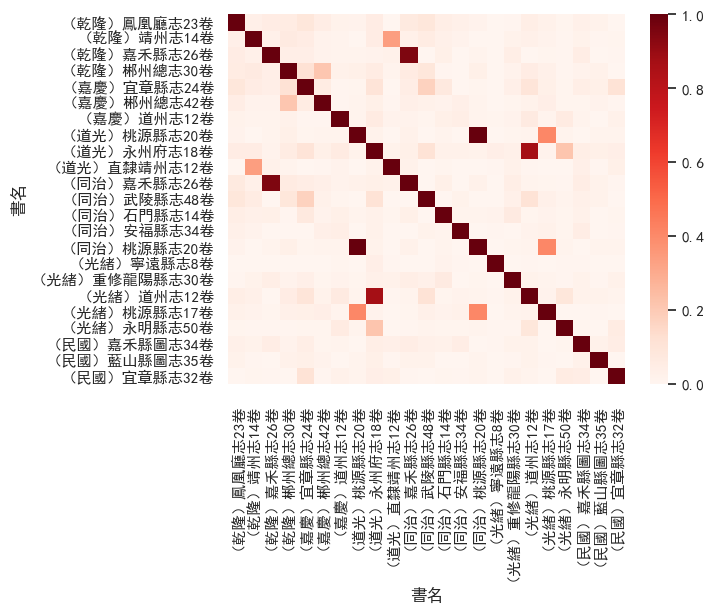

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(cos_sim, font='SimHei', font_scale=1, cmap="Reds"):
    """
    cos_sim: pd.DataFrame結構的二維矩陣；
    font：字體；font_scale：字體大小；cmap：顏色映射；
    """
    sns.set(font=font, font_scale=font_scale)
    xticklabels = cos_sim.index.tolist()
    yticklabels = cos_sim.columns.tolist()
    ax = sns.heatmap(cos_sim, cmap=cmap, xticklabels=xticklabels, yticklabels=yticklabels)
    
    # 旋轉x軸標籤並設置水平對齊
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # 確保每個標籤最後的字在旋轉後正對著相應刻度
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
    
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('right')
    
    return ax


heatmap = heatmap(cos_sim)
